In [1]:
import glob
import torch
import numpy as np
import pylelemmatize
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def get_model_accuracy(model_path):
    model = pylelemmatize.DemapperLSTM.resume(model_path)
    epoch_accuracies = sorted(model.history['valid_acc'].items())
    std = np.std([epoch_accuracies[k][1] for k in range(len(epoch_accuracies)//2, len(epoch_accuracies))], ddof=1)
    acc = epoch_accuracies[-1][1]
    return acc, min(acc, std)

def load_sz_models():
    files = glob.glob("./models/curve_mufi2ascii_koening*")
    linecount2cer_std = {}
    for file in files:
        acc, std = get_model_accuracy(file)
        cer = 1. - acc
        texline_count = int(file.split("_")[-2][7:])
        linecount2cer_std[texline_count]=(cer, std)
    res = np.array([(k, v[0], v[1]) for k, v in sorted(linecount2cer_std.items())])
    return res[:, 0].astype(np.int64), res[:, 1], res[:, 2]

def plot_history(model_filename):
    m = pylelemmatize.DemapperLSTM.resume("./models/curve_mufi2ascii_koening3000_simple.pt")

labels, cer, std = load_sz_models()
labels= [f"{sz}" for sz in labels.tolist()]
cer=cer.tolist()
std=std.tolist()
#labels[-1]="Mapper"
#cer[-1]=0.0294
#std[-1]=0.

In [2]:
df = pd.DataFrame({
    'label': labels,
    'cer': [100*err for err in cer],
    'variance': [100*v for v in std],
})
new_row = pd.DataFrame({'label': ['lemmatizer'], 'cer': [2.99], 'variance': [0.]})

# Add row
df = pd.concat([df, new_row], ignore_index=True)

/tmp/ipykernel_3994033/970326093.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=df, x='label', y='cer', ci=None) #errorbar=std)    disables bootstrapped CIs


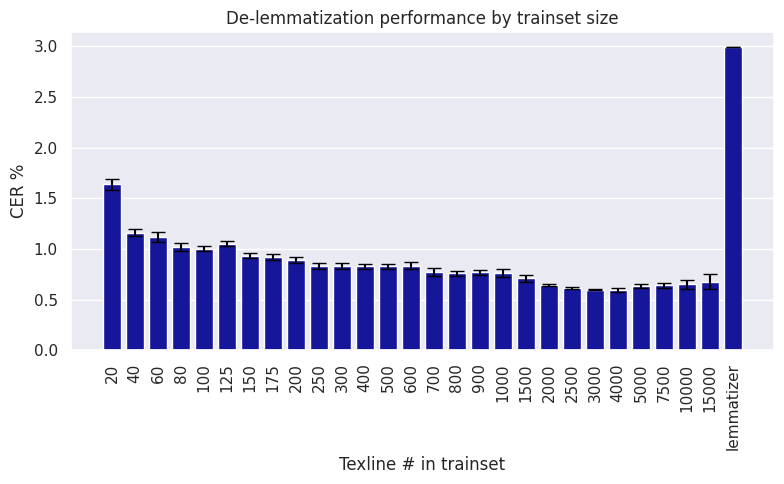

In [3]:
sns.set_theme(style="darkgrid", palette="seismic")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df, x='label', y='cer', ci=None) #errorbar=std)    disables bootstrapped CIs

# Add error bars manually
ax.errorbar(
    x=range(len(df)),
    y=df['cer'],
    yerr=df['variance'],
    fmt='none',
    c='black',
    capsize=5
)
plt.xticks(rotation=90)

# Labels and layout
ax.set_title("De-lemmatization performance by trainset size")
ax.set_ylabel("CER %")
ax.set_xlabel("Texline # in trainset")
plt.tight_layout()
plt.savefig("demmaping_trainset_size.pdf")
plt.show()

In [4]:
table_files = [f for f in glob.glob("./models/*pt") if not f.startswith("curve")]
for file in table_files:
    pass